<html>
    <div style="
    background-color: green;
    color: white;
    padding: 30px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h1>Image Generation Using Variational Autoencoders (VAEs)</h1>
</div>
</html>


## Variational Autoencoders (VAEs)

![VAE Architecture](https://github.com/shivamshinde123/Kaggle-Notebooks/blob/main/Images/VAE_Architecture.png?raw=true)

Variational Autoencoders (VAEs) can be viewed as a non-linear extension of the Probabilistic Principal Component Analysis (p-PCA) model. While VAEs are similar to traditional autoencoders, the key difference is that VAEs enforce an **approximate normal distribution** in the latent space. This constraint improves the model's ability to capture the underlying data structure and enables more effective sampling and generation.

We cannot generate realistic images using only the trained decoder of an autoencoder because the probability distribution of the latent space is unknown. 
To address this, we enforce the latent space to follow an approximate normal distribution, allowing us to sample from it and generate realistic images. Also, we assume the decoder output as the mean of the distribution of the generated images. So, we add some noise to the decoder output to get the final generated image. This is the core idea behind Variational Autoencoders (VAEs).

To ensure the latent space approximates a normal distribution, we output the mean and standard deviation of the distribution, and then sample from it to serve as input to the decoder.
However, the challenge lies in the fact that the sampling operation in the latent space is not differentiable. If left as-is, this prevents us from updating the encoder's parameters via backpropagation.

![Reparameterization Trick in VAE](https://github.com/shivamshinde123/Kaggle-Notebooks/blob/main/Images/reparameterization_in_VAE.png?raw=true)


To address the challenge of non-differentiable sampling in the latent space, we use a technique called the **reparameterization trick.**

In its basic form, the VAE can suffer from a problem known as posterior collapse. This occurs when the encoder's learned distribution becomes too similar to the prior (a standard normal distribution), causing the latent variables to lose meaningful information about the input. As a result, the decoder relies primarily on the prior, reducing the model's ability to generate diverse and informative outputs.

This collapse happens due to the KL divergence term in the loss function, which encourages the latent space distribution to match a normal distribution. To mitigate this issue, a common approach is to introduce a hyperparameter β (as in **β-VAE**), which scales the KL divergence term.

- If β is small (close to 0), the KL term is given less weight, allowing the latent space to retain more meaningful structure and preventing it from collapsing to the prior.
- If β is large (≥1), the latent space is forced to resemble a normal distribution more strictly, increasing the risk of posterior collapse.

Thus, β is a crucial hyperparameter that needs to be carefully tuned to balance the trade-off between meaningful latent representations and regularization, ultimately improving the quality of generated data.

<html>
    <div style="
    background-color: pink;
    color: black;
    padding: 10px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Importing Required Packages</h3>
</div>
</html>

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

<html>
    <div style="
    background-color: pink;
    color: black;
    padding: 10px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Creating a Class to Load the Data</h3>
</div>
</html>

In [2]:
class FaceDataset(Dataset):

    def __init__(self, faces_numpy_filepath, transform=None):
        self.images = np.load(faces_numpy_filepath)
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):

        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0) # (24, 24) --> (1, 24, 24) for compliance with pytorch I/P shapes

        return image

<html>
    <div style="
    background-color: pink;
    color: black;
    padding: 10px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Creating an Encoder</h3>
</div>
</html>

In [3]:
class Encoder(nn.Module):

    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1)
        # Input: (batch_size, 1, 24, 24)
        # Output: (batch_size, 32, 12, 12)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        # Input: (batch_size, 32, 12, 12)
        # Output: (batch_size, 64, 6, 6)

        # compute the flattened feature size after conv layer
        self.flatten_dim = 64 * 6 * 6

        # Two linear layers to compute mean and log variance for latent variable z
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        # Input: (batch_size, 64*6*6)
        # Output: (batch_size, latent_dim)

        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)
        # Input: (batch_size, 64*6*6)
        # Output: (batch_size, latent_dim)

    def forward(self, x):

        # pass through CNN layers with relu activation function
        if x.dim() == 3:
            x = x.unsqueeze(1)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # flatten the output of CNN layers for the fully-connected layers
        x = x.view(x.size(0), -1)
        
        # mean and log variance calculation
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

<html>
    <div style="
    background-color: pink;
    color: black;
    padding: 10px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Creating a Decoder</h3>
</div>
</html>

In [4]:
class Decoder(nn.Module):

    def __init__(self, latent_dim):
        super(Decoder, self).__init__()

        # map the latent vector back to a feature map
        self.fc = nn.Linear(latent_dim, 64*6*6)
        # Input: (batch_size, latent_dim)
        # Output: (batch_size, 64*6*6)

        # transposed convolutions for upsampling to the original image size (24x24)
        self.trans_conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.trans_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        # map the latent vector to feature map
        x = self.fc(z)

        x = x.view(x.size(0), 64, 6, 6)

        x = F.relu(self.trans_conv1(x))
        
        # use a sigmoid activation to constrain the output to [0, 1]
        x = torch.sigmoid(self.trans_conv2(x))

        if x.dim() == 3:
            x = x.unsqueeze(1)

        return x

<html>
    <div style="
    background-color: pink;
    color: black;
    padding: 10px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Joining Together Encoder and Decoder to Create a VAE</h3>
</div>
</html>

In [5]:
class VAE(nn.Module):

    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        # perform the reparameterization trick to enable backpropogation
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # encode input to get distribution parameters
        mu, logvar = self.encoder(x)

        # sample z using the reparameterization trick
        z = self.reparameterize(mu, logvar)

        # decode z to reconstruct the image
        recon_x = self.decoder(z)

        return recon_x, mu, logvar

<html>
    <div style="
    background-color: pink;
    color: black;
    padding: 10px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Creating a Loss Function</h3>
</div>
</html>

In [6]:
def loss_function(recon_x, x, mu, logvar, beta=0.6):

    # reconstruction loss (using BCE loss as we use sigmoid in the decoder)
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return bce + beta * kld

<html>
    <div style="
    background-color: pink;
    color: black;
    padding: 10px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Creating the Functions for Training</h3>
</div>
</html>

In [7]:
def train_vae(model, dataloader, optimizer, device, epochs=10, beta=1.0):

    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, data in enumerate(dataloader):

            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, beta)
            loss.backward()
            train_loss += loss
            optimizer.step()

            if batch_idx % 5 == 0:
                print(f'Epoch {epoch+1} [{batch_idx * len(data)}/{len(dataloader.dataset)}] Loss: {loss.item() / len(data):.4f}')

        print(f'====> Epoch: {epoch+1} Average loss: {train_loss / len(dataloader.dataset):.4f}')

In [8]:
def main_train(batch_size, latent_dim, learning_rate, epochs, beta, model_name="img_generation_model.pth"):

    # device configuration 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # data preprocessing and loading
    transform = transforms.Compose(
        transforms.ToTensor()
    )

    dataset = FaceDataset("/kaggle/input/face-images/faces_vae.npy")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # initialize model, optimizer 
    model = VAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # train the VAE
    train_vae(model, dataloader, optimizer, device, epochs=epochs, beta=beta)

    # saving the trained model
    os.makedirs(os.path.join("/kaggle/working/", "Models"), exist_ok=True)

    torch.save(model.state_dict(), os.path.join("/kaggle/working/", "Models", model_name))

<html>
    <div style="
    background-color: pink;
    color: black;
    padding: 10px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Creating a Function to Generate New Data</h3>
</div>
</html>

In [9]:
def main_generate_images(model_path, latent_dim, num_images=100, grid_size=(10, 10), save_path=os.path.join("/kaggle/working/", 'Images', "generated_images.png")):
    
    # Load the trained VAE model
    vae = VAE(latent_dim)  
    vae.load_state_dict(torch.load(model_path, weights_only=True))

    # Set the decoder to evaluation mode
    decoder = vae.decoder
    decoder.eval()

    # Generate images
    all_images = []
    for i in range(num_images):
        z = torch.randn(1, latent_dim)  # Sample random latent vector
        with torch.no_grad():
            generated_image = decoder(z)  # Generate image
            generated_image = generated_image.reshape(24, 24)  # Reshape to (24, 24)
            all_images.append(generated_image)

    # Plot images in a 10x10 grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(all_images[i], cmap='gray')  # Display the image in grayscale
        ax.axis('off')  # Hide axes

    plt.tight_layout()

    # Save the grid to a file
    os.makedirs(os.path.join("/kaggle/working/", 'Images'), exist_ok=True)

    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)

    plt.show()

<html>
    <div style="
    background-color: pink;
    color: black;
    padding: 10px 20px;
    display: inline-block;
    border-radius: 8px;
    font-size: 24px;
    font-weight: bold;
    text-align: center;
    margin: 20px auto;
    display: block;
    width: fit-content;"
    <h3>Generating the New Data</h3>
</div>
</html>

Epoch 1 [0/23042] Loss: 403.4242
Epoch 1 [320/23042] Loss: 399.6850
Epoch 1 [640/23042] Loss: 398.4045
Epoch 1 [960/23042] Loss: 394.7143
Epoch 1 [1280/23042] Loss: 392.1565
Epoch 1 [1600/23042] Loss: 385.0571
Epoch 1 [1920/23042] Loss: 379.9363
Epoch 1 [2240/23042] Loss: 377.3176
Epoch 1 [2560/23042] Loss: 370.9026
Epoch 1 [2880/23042] Loss: 367.4842
Epoch 1 [3200/23042] Loss: 373.7623
Epoch 1 [3520/23042] Loss: 375.9421
Epoch 1 [3840/23042] Loss: 370.5971
Epoch 1 [4160/23042] Loss: 369.1534
Epoch 1 [4480/23042] Loss: 366.0887
Epoch 1 [4800/23042] Loss: 372.5137
Epoch 1 [5120/23042] Loss: 362.2240
Epoch 1 [5440/23042] Loss: 366.4479
Epoch 1 [5760/23042] Loss: 367.2964
Epoch 1 [6080/23042] Loss: 365.7861
Epoch 1 [6400/23042] Loss: 368.4383
Epoch 1 [6720/23042] Loss: 368.5731
Epoch 1 [7040/23042] Loss: 370.3829
Epoch 1 [7360/23042] Loss: 364.4466
Epoch 1 [7680/23042] Loss: 372.0522
Epoch 1 [8000/23042] Loss: 372.5479
Epoch 1 [8320/23042] Loss: 366.2116
Epoch 1 [8640/23042] Loss: 363.375

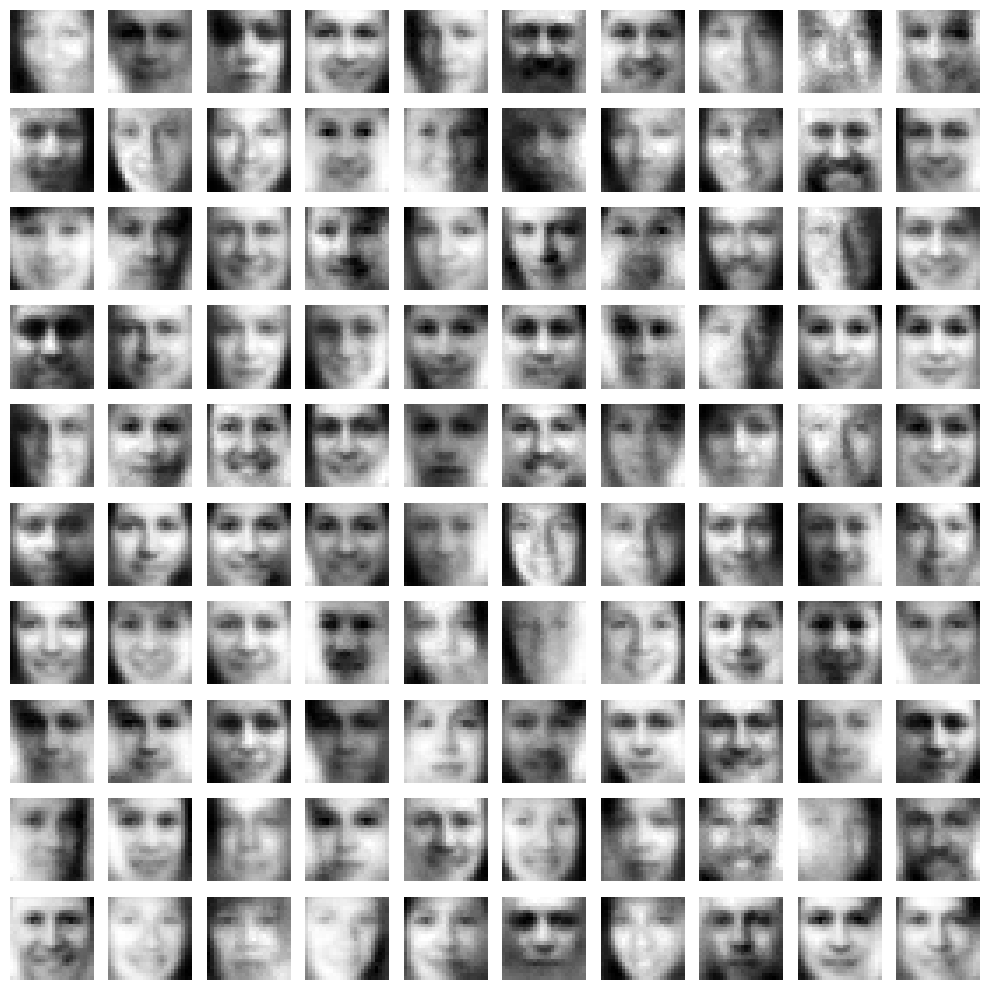

In [10]:
# hyperparameters
latent_dim = 20
batch_size = 64
epochs = 5
learning_rate = 1e-3
beta = 0.5

# train the model
main_train(batch_size, latent_dim, learning_rate, epochs, beta)

# use trained model to generate an image
model_path = os.path.join("/kaggle/working/", "Models", "img_generation_model.pth")
main_generate_images(model_path, latent_dim=latent_dim, num_images=100, grid_size=(10, 10))